# Example EXACT flight-like data
## Download required data from [here](https://drive.google.com/drive/folders/1rj1OqJoHB9ozBfMHl_peUsiJqZvmRokl?usp=sharing)
This notebook just loads in one piece of chunk data file and plots it.
A similar approach could be used to read in more of the data.

Requires some packages to be installed:
```bash
pip install numpy matplotlib
```

And, need to install a Python package from GitHub:
```bash
git clone https://github.com/umn-impish/umn-detector-code
cd umn-detector-code
git checkout exact-implementation
cd python
pip install -e .[all]
```

Eventually the `exact-implementation` branch will get deleted.
In this case, do not do the `checkout` command.

In [1]:
import gzip
from umndet.common import helpers as hp
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import datetime

import matplotlib.pyplot as plt
import os
plt.style.use(os.getenv('MPL_INTERACTIVE_STYLE'))

## Load in the data

In [2]:
fold = 'nrl-example'
files = os.listdir(fold)
test_file = files[0]
nrl_data = hp.read_stripped_nrl_list(f'{fold}/{test_file}', open_func=gzip.open)

## Extract some data from the structs we've read in

In [3]:
chosen_data = nrl_data[3]
dat = chosen_data['events']
energies, times, pps = [], [], []

energies += [t.energy for t in dat]
times += [t.relative_timestamp for t in dat]
pps += [e.was_pps for e in dat]

In [4]:
pps_times = []
pps_indices = []
for i, e in enumerate(dat):
    if not e.was_pps: continue
    pps_times.append(e.relative_timestamp)
    pps_indices.append(i)

## Apply a small amount of processing to turn the relative timestamps into the absolute timestamps

In [5]:
time_after = chosen_data['unix_time']
last_pps = pps_times[-1]

# Get the time difference from everything relative to the
# last recorded PPS
adjusted = [t - last_pps for t in times]
deltas = [datetime.timedelta(microseconds=t/5) for t in adjusted]
anchor = datetime.datetime.fromtimestamp(time_after, datetime.timezone.utc)

# Add timedeltas onto the anchor--assumes the anchor
# actually corresponds to the last PPS
abs_times = [anchor + d for d in deltas]
pps_real_times = [abs_times[i] for i in pps_indices]

## Now, plot it

In [6]:
import matplotlib as mpl
import matplotlib.axes
import matplotlib.dates as mdates

def concise_dates(ax: mpl.axes.Axes) -> None:
    loc = mdates.AutoDateLocator()
    fmt = mdates.ConciseDateFormatter(loc)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(fmt)


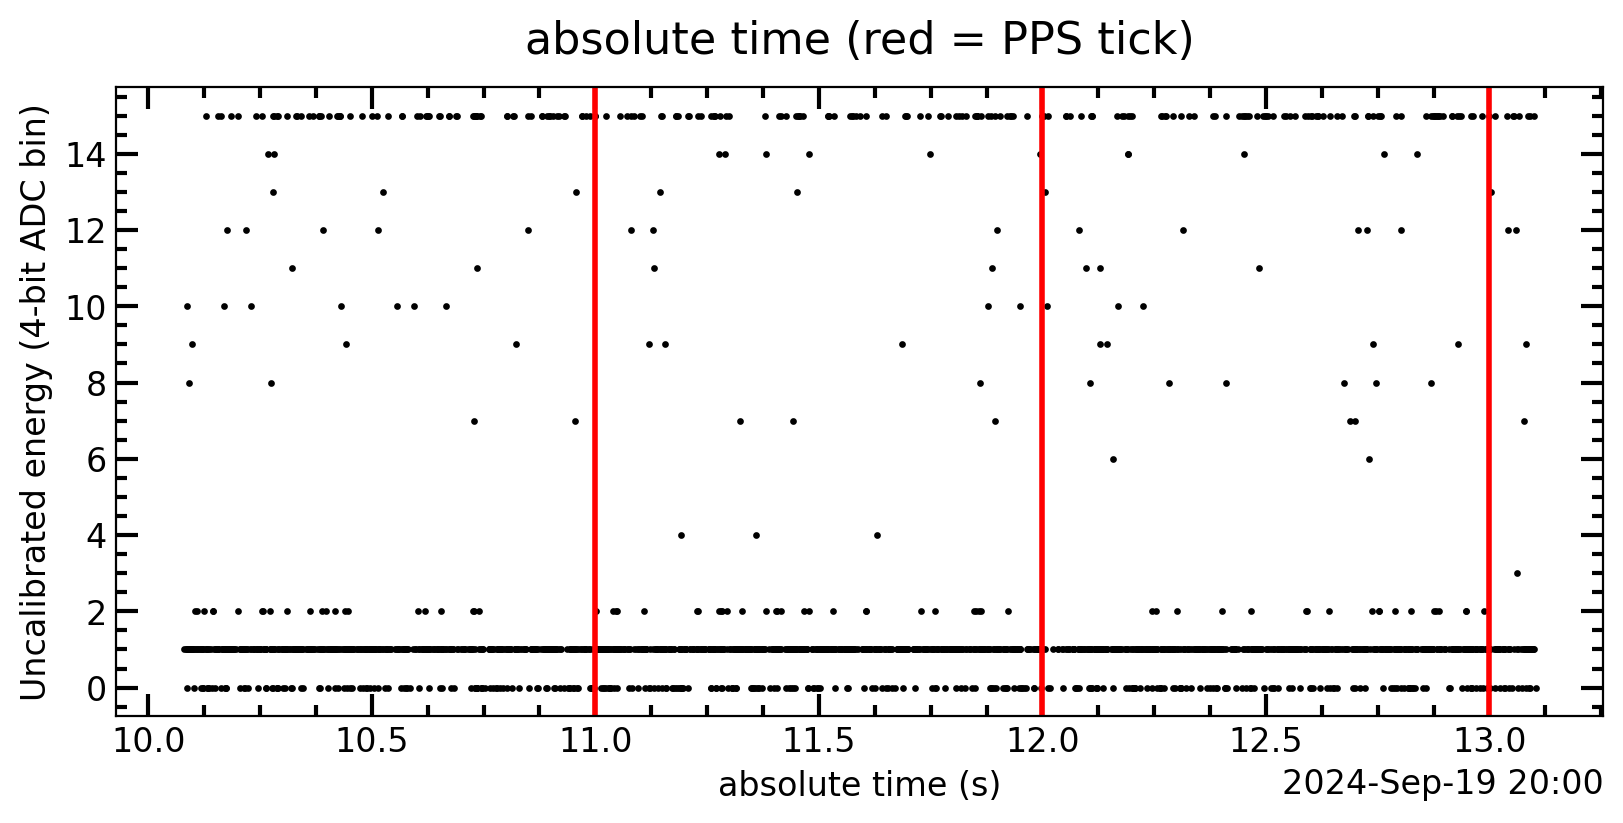

In [7]:
fig, ax = plt.subplots(layout='constrained')
concise_dates(ax)
ax.scatter(abs_times, energies, s=2, color='black')

for rt in pps_real_times:
    ax.axvline(rt, color='red')

ax.set(
    xlabel='absolute time (s)',
    ylabel='Uncalibrated energy (4-bit ADC bin)',
    title='absolute time (red = PPS tick)'
)

plt.show()